In [14]:
#import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import matplotlib.pyplot as plt # Library to plot data

print('Libraries imported.')

Libraries imported.


In [15]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [16]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [17]:
json_data = newyork_data['features']

In [18]:
json_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [19]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
nydf = pd.DataFrame(columns=column_names)

In [20]:
nydf.head()

,Borough,Neighborhood,Latitude,Longitude


In [21]:
for data in json_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    nydf = nydf.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [22]:
nydf.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [23]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nydf['Borough'].unique()),
        nydf.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


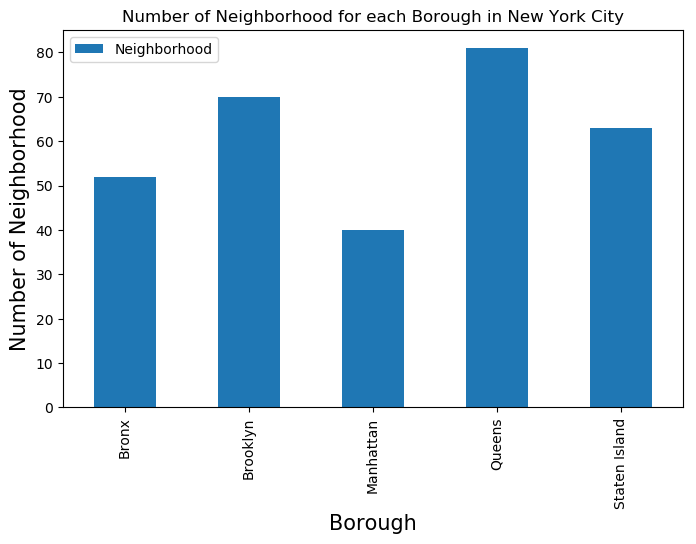

In [24]:
%matplotlib inline

plt.figure(figsize=(8,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Neighborhood', fontsize=15)
#giving a bar plot
nydf.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [25]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'Y2MQTFDXRP25NUSFS4XT5EPM3RWHVVDXQURS4GARWWERRBP0' # your Foursquare ID
    CLIENT_SECRET = 'HLGAWVJ43MCVLWTTPFXNLVVR1PDT3FEXPGFOSNUJ01F2FSKV' # your Foursquare Secret
    VERSION = '20190605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [26]:
column_names=['Borough', 'Neighborhood','Latitude','Longitude','ID','Name','Category']
indian_rest_ny=pd.DataFrame(columns=column_names)
#count=1
for row in nydf.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude, Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 'Latitude': Latitude,'Longitude': Longitude,
                                                'ID': id,
                                                'Name' : name, 'Category': category
                                               }, ignore_index=True)
    #count+=1

In [27]:
indian_rest_ny.head()

,Borough,Neighborhood,Latitude,Longitude,ID,Name,Category
0,Bronx,Woodlawn,40.898273,-73.867315,4c0448d9310fc9b6bf1dc761,Curry Spot,Indian Restaurant
1,Bronx,Williamsbridge,40.881039,-73.857446,570c3a3fcd10eecd0d0434cd,Agra Grill,Indian Restaurant
2,Bronx,Parkchester,40.837938,-73.856003,4c194631838020a13e78e561,Melanies Roti Bar And Grill,Indian Restaurant
3,Bronx,Spuyten Duyvil,40.881395,-73.917190,4c04544df423a593ac83d116,Cumin Indian Cuisine,Indian Restaurant
4,Bronx,Concourse,40.834284,-73.915589,551b7f75498e86c00a0ed2e1,Hungry Bird,Indian Restaurant


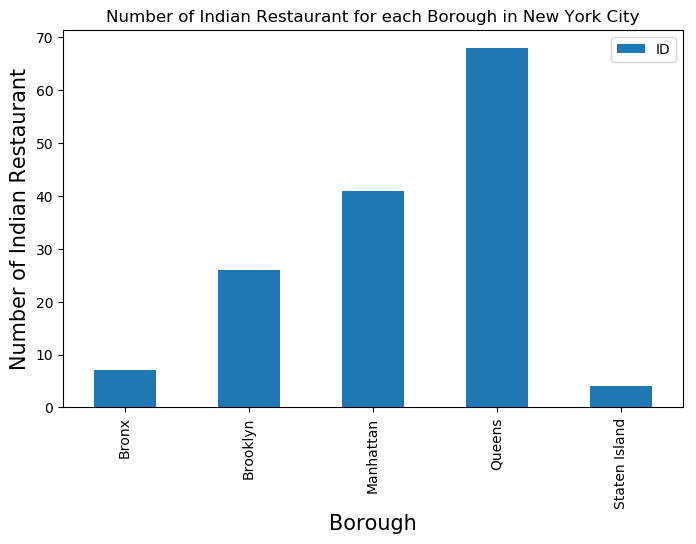

In [28]:

%matplotlib inline

plt.figure(figsize=(8,5), dpi = 100)
# title
plt.title('Number of Indian Restaurant for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

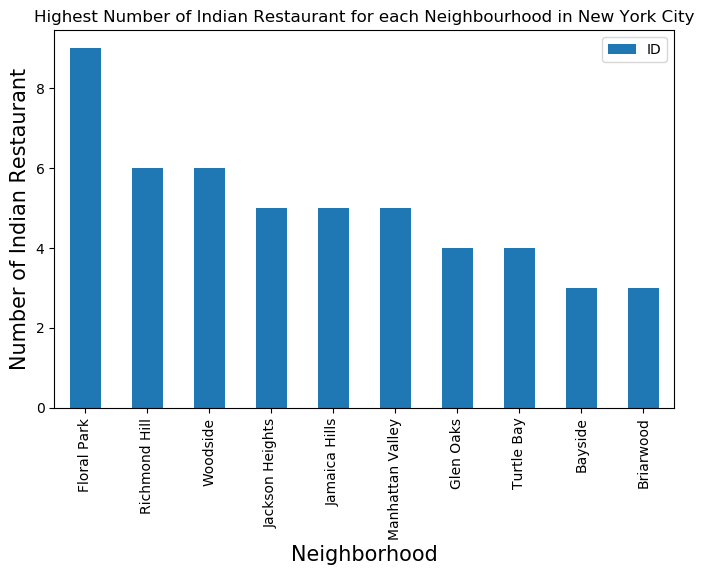

In [29]:
%matplotlib inline

plt.figure(figsize=(8,5), dpi = 100)
# title
plt.title('Highest Number of Indian Restaurant for each Neighbourhood in New York City')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(10).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

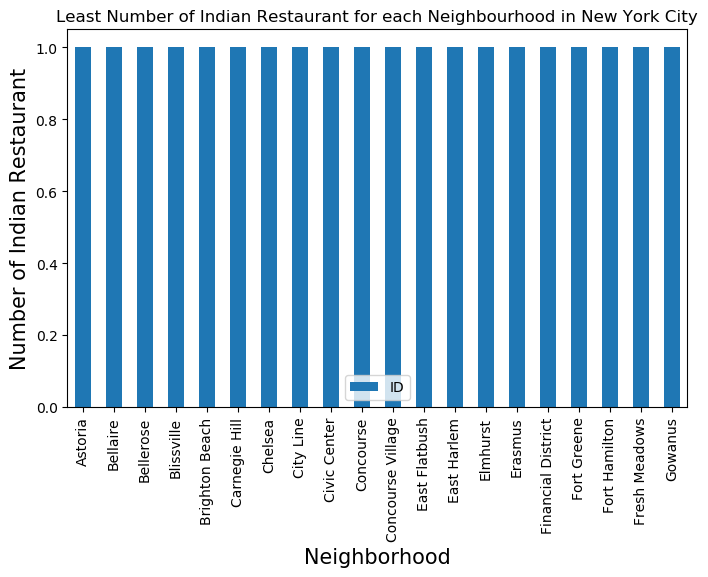

In [32]:
%matplotlib inline

plt.figure(figsize=(8,5), dpi = 100)
# title
plt.title('Least Number of Indian Restaurant for each Neighbourhood in New York City')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Indian Restaurant', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nsmallest(20).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [43]:
# create map of Indian Restaurants in NY using latitude and longitude values
map_newyork = folium.Map(location=[Latitude, Longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(indian_rest_ny['Latitude'], indian_rest_ny['Longitude'], indian_rest_ny['Borough'], indian_rest_ny['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork